In [1]:
import json
import pandas as pd
import numpy as np
import joblib
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# =============================================
# 1. Data Loading and Preprocessing
# =============================================
with open('cowrie.json') as f:
    data = [json.loads(line) for line in f]

df = pd.DataFrame(data)
print(f"Total records: {len(df)}")

# Data Cleaning
df = df.dropna(subset=['src_ip', 'eventid'])
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp')

# Fill missing values
df['username'] = df['username'].fillna('unknown')
df['password'] = df['password'].fillna('')
df['duration'] = pd.to_numeric(df['duration'], errors='coerce').fillna(0)

# =============================================
# 2. Feature Engineering
# =============================================
# Time-based features
df['hour'] = df['timestamp'].dt.hour
df['time_since_first'] = (df['timestamp'] - df['timestamp'].min()).dt.total_seconds()
df['time_since_last'] = df.groupby('src_ip')['timestamp'].diff().dt.total_seconds().fillna(0)

# Behavioral features
df['login_success'] = df['eventid'].apply(lambda x: 1 if x == 'cowrie.login.success' else 0)
df['login_failed'] = df['eventid'].apply(lambda x: 1 if x == 'cowrie.login.failed' else 0)
df['login_attempts'] = df.groupby('src_ip')['eventid'].transform(lambda x: x.str.contains('login').sum())
df['success_rate'] = df.groupby('src_ip')['login_success'].transform('mean')

# Security-specific features
df['password_length'] = df['password'].str.len().fillna(0)
df['is_common_username'] = df['username'].isin(['admin', 'root', 'test']).astype(int)
df['is_common_password'] = df['password'].isin(['123456', 'password', 'admin']).astype(int)
df['suspicious_command'] = df['input'].str.contains('wget|curl|chmod|rm -rf|sudo', case=False).fillna(0).astype(int)

# Define attack types based on behavioral patterns
df['attack_type'] = 'normal'  # Default label

# Brute Force: High attempts, low success
df.loc[(df['login_attempts'] > 5) & (df['success_rate'] < 0.1), 'attack_type'] = 'brute_force'

# Credential Stuffing: Common credentials
common_creds = df['is_common_username'].astype(bool) | df['is_common_password'].astype(bool)
df.loc[common_creds, 'attack_type'] = 'credential_stuffing'


# Verify class distribution
print("\nAttack Type Distribution:")
print(df['attack_type'].value_counts())

# =============================================
# 3. Encoding Implementation
# =============================================
ip_encoder = LabelEncoder()
user_encoder = LabelEncoder()
event_encoder = LabelEncoder()

ip_encoder.fit(pd.concat([df['src_ip'], pd.Series(['unknown'])])) # Fit on all values including 'unknown'
user_encoder.fit(pd.concat([df['username'], pd.Series(['unknown'])]))
event_encoder.fit(pd.concat([df['eventid'], pd.Series(['UNK_EVENT'])]))

df['src_ip_encoded'] = ip_encoder.transform(df['src_ip'])
df['username_encoded'] = user_encoder.transform(df['username'])
df['event_encoded'] = event_encoder.transform(df['eventid'])

# =============================================
# 4. Model Training with Proper Pipeline
# =============================================
features = [
    'src_ip_encoded',
    'username_encoded',
    'hour',
    'duration',
    'login_attempts',
    'success_rate',
    'time_since_first',
    'time_since_last',
    'password_length',
    'is_common_username',
    'is_common_password',
    'suspicious_command'
]

X = df[features]
y = df['attack_type']

# Before splitting, handle NaNs:
X.fillna(X.mean(), inplace=True)  # Replace NaNs with the mean of each column

# Handle NaNs in 'y' by replacing with the most frequent category:
y.fillna(y.mode()[0], inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Improved Pipeline with SMOTE and Class Weighting
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42, k_neighbors=3)),
    ('rf', RandomForestClassifier(class_weight='balanced', random_state=42))
])

param_grid = {
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [10, 20, None],
    'rf__min_samples_split': [2, 5],
    'rf__max_features': ['sqrt']
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=StratifiedKFold(n_splits=3),
    scoring='f1_weighted',
    verbose=2
)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

# =============================================
# 5. Evaluation and Model Saving
# =============================================
y_pred = best_model.predict(X_test)
# After model training
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=df['attack_type'].unique()))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
# Save complete model package
final_package = {
    'model': best_model,
    'encoders': {
        'ip': ip_encoder,
        'user': user_encoder,
        'event': event_encoder
    },
    'metadata': {
        'features': features,
        'thresholds': {
            'brute_force': 0.7,
            'credential_stuffing': 0.6,  # Lower threshold for rare class
            'normal': 0.9
        },
        'training_date': datetime.now().strftime("%Y-%m-%d")
    }
}

joblib.dump(final_package, 'prod_model_v1.pkl')


Total records: 4192

Attack Type Distribution:
attack_type
normal                 3883
credential_stuffing     200
brute_force             109
Name: count, dtype: int64
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END rf__max_depth=10, rf__max_features=sqrt, rf__min_samples_split=2, rf__n_estimators=100; total time=   0.1s


/var/folders/5f/dj1y3d016zn3lsgbd7584d_00000gn/T/ipykernel_2045/2496720918.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(X.mean(), inplace=True)  # Replace NaNs with the mean of each column


[CV] END rf__max_depth=10, rf__max_features=sqrt, rf__min_samples_split=2, rf__n_estimators=100; total time=   0.2s
[CV] END rf__max_depth=10, rf__max_features=sqrt, rf__min_samples_split=2, rf__n_estimators=100; total time=   0.2s
[CV] END rf__max_depth=10, rf__max_features=sqrt, rf__min_samples_split=2, rf__n_estimators=200; total time=   0.3s
[CV] END rf__max_depth=10, rf__max_features=sqrt, rf__min_samples_split=2, rf__n_estimators=200; total time=   0.3s
[CV] END rf__max_depth=10, rf__max_features=sqrt, rf__min_samples_split=2, rf__n_estimators=200; total time=   0.3s
[CV] END rf__max_depth=10, rf__max_features=sqrt, rf__min_samples_split=5, rf__n_estimators=100; total time=   0.1s
[CV] END rf__max_depth=10, rf__max_features=sqrt, rf__min_samples_split=5, rf__n_estimators=100; total time=   0.1s
[CV] END rf__max_depth=10, rf__max_features=sqrt, rf__min_samples_split=5, rf__n_estimators=100; total time=   0.1s
[CV] END rf__max_depth=10, rf__max_features=sqrt, rf__min_samples_split=

['prod_model_v1.pkl']

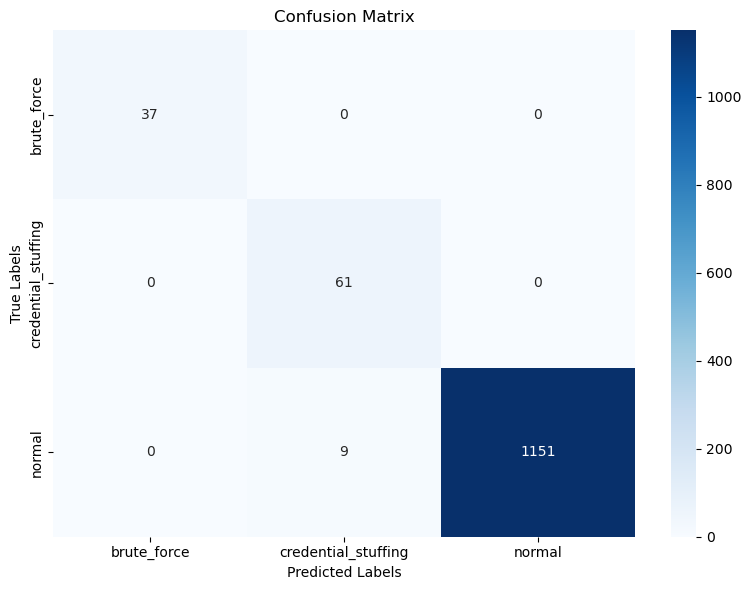

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=best_model.classes_, 
            yticklabels=best_model.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

/var/folders/5f/dj1y3d016zn3lsgbd7584d_00000gn/T/ipykernel_2045/3349913545.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_features, x='Importance', y='Feature', palette='viridis')


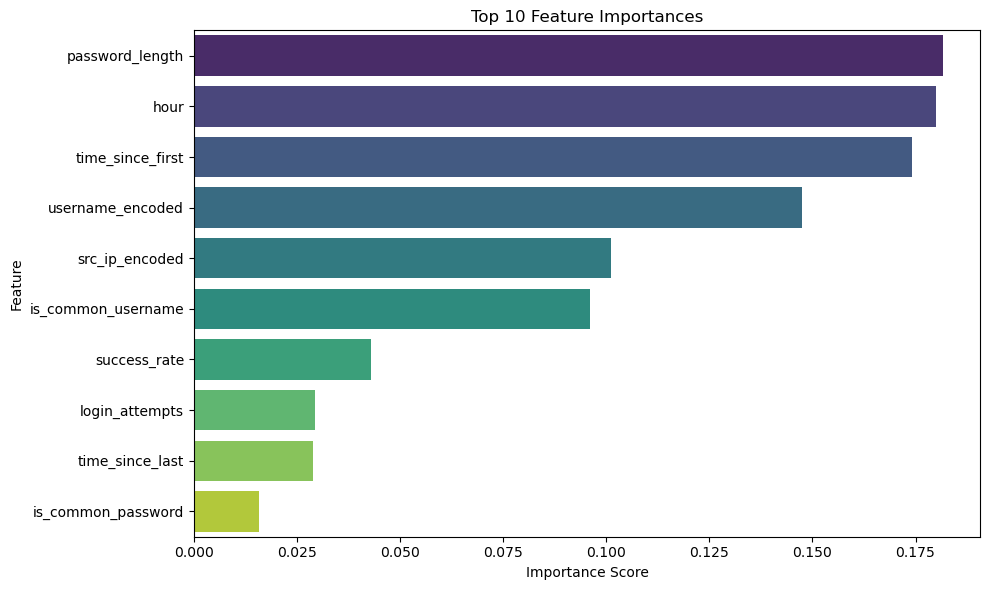

In [4]:
importances = best_model.named_steps['rf'].feature_importances_
feature_names = features

# Create DataFrame of features and their importances
feat_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort and select top 10
top_features = feat_importance_df.sort_values(by='Importance', ascending=False).head(10)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(data=top_features, x='Importance', y='Feature', palette='viridis')
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [2]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(best_model, X_train, y_train, cv=3, scoring='accuracy')
print(f"Cross-validation scores: {scores}")
print(f"Average CV accuracy: {scores.mean()}")

Cross-validation scores: [0.99488753 0.98977505 0.99591002]
Average CV accuracy: 0.9935241990456714
